In [1]:
import os
import cv2
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./clustering2.csv', encoding='utf-8', index_col=0)

In [3]:
from sklearn.model_selection import train_test_split

X = []
y = []

path = 'C:/Users/sanghui/Desktop/toyproject/DL_Project_5/hsh/data/2_15_crop'

for i in tqdm_notebook(range(5)):
    random_set = np.random.choice(df[df['cluster']==i]['filename'].values, 2400, replace=False)
    for file in random_set:
        file_path = path + '/' + file
        src = cv2.imread(file_path, cv2.IMREAD_COLOR)
        dst = cv2.resize(src, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
        X.append(dst)
        y.append(df[df['filename'] == file]['cluster'].values[0]) 

C:\Users\sanghui\AppData\Local\Temp/ipykernel_17908/2470885059.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(5)):


  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

X_train, X_test = X_train/255.0, X_test/225.0

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications
from keras.applications.inception_v3 import preprocess_input


input_shape = (299, 299, 3)

base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(5, activation='softmax'))

model = add_model

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
300/300 [==============================] - 479s 2s/step - loss: 0.5422 - accuracy: 0.7857 - val_loss: 0.3505 - val_accuracy: 0.8629
Epoch 2/10
300/300 [==============================] - 464s 2s/step - loss: 0.3554 - accuracy: 0.8554 - val_loss: 0.3232 - val_accuracy: 0.8708
Epoch 3/10
300/300 [==============================] - 468s 2s/step - loss: 0.3343 - accuracy: 0.8607 - val_loss: 0.3380 - val_accuracy: 0.8621
Epoch 4/10
300/300 [==============================] - 478s 2s/step - loss: 0.3152 - accuracy: 0.8707 - val_loss: 0.3056 - val_accuracy: 0.8854
Epoch 5/10
300/300 [==============================] - 477s 2s/step - loss: 0.3060 - accuracy: 0.8771 - val_loss: 0.3299 - val_accuracy: 0.8667
Epoch 6/10
300/300 [==============================] - 474s 2s/step - loss: 0.3032 - accuracy: 0.8783 - val_loss: 0.3080 - val_accuracy: 0.8775
Epoch 7/10
300/300 [==============================] - 478s 2s/step - loss: 0.2984 - accuracy: 0.8763 - val_loss: 0.3024 - val_accuracy: 0.8821

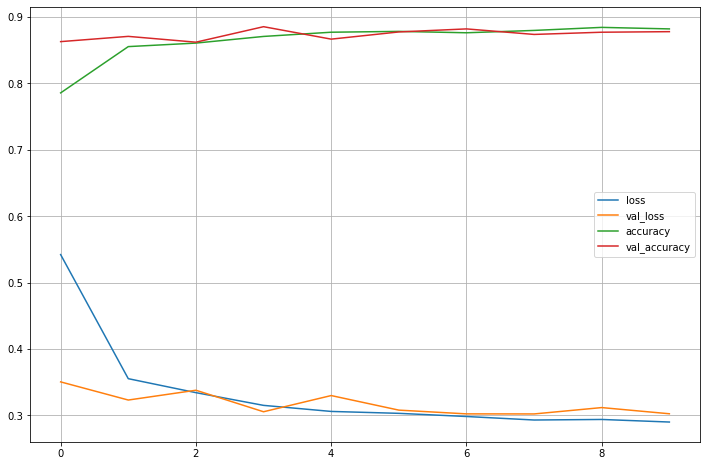

In [7]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12, 8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [8]:
model.save_weights('model-weights.h5')

In [9]:
model.save('model_whole.h5')

In [10]:
model.evaluate(X_test, y_test)

75/75 [==============================] - 85s 1s/step - loss: 0.3025 - accuracy: 0.8779


[0.30252277851104736, 0.877916693687439]

In [13]:
from tensorflow.keras.models import Model

get_vector = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)

In [14]:
# load data
features = []

path = 'C:/Users/sanghui/Desktop/toyproject/DL_Project_5/hsh/data/2_15_crop'

for image in tqdm_notebook(os.listdir(path)):
    file_path = path + '/' + image
    src = cv2.imread(file_path, cv2.IMREAD_COLOR)
    dst = cv2.resize(src, dsize=(299,299), interpolation=cv2.INTER_CUBIC)
    img_data = np.expand_dims(dst, axis=0)
    img_data = preprocess_input(img_data)
    features.append(model.predict(img_data)[0])

C:\Users\sanghui\AppData\Local\Temp/ipykernel_17908/1180965705.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image in tqdm_notebook(os.listdir(path)):


  0%|          | 0/51260 [00:00<?, ?it/s]

In [15]:
# calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(features, features)

In [16]:
tuning_result = pd.DataFrame(cosine_sim, columns=os.listdir(path), index=os.listdir(path))

In [17]:
tuning_result.head()

,0.jpg,1.jpg,10.jpg,100.jpg,1000.jpeg,10000.jpg,10001.jpg,10002.jpg,10003.jpg,10004.jpg,...,9990.jpg,9991.jpg,9992.jpg,9993.jpg,9994.jpg,9995.jpg,9996.jpg,9997.jpg,9998.jpg,9999.jpg
0.jpg,1.000000,0.060404,0.306862,0.309711,0.000923,8.258298e-05,0.002136,0.000047,0.040525,0.000075,...,0.090411,0.950543,0.947155,0.951081,0.950827,0.949011,1.384753e-02,0.923397,0.950886,8.239874e-05
1.jpg,0.060404,1.000000,0.293072,0.190188,0.669695,2.678867e-06,0.721488,0.721979,0.952804,0.723625,...,0.694109,0.027464,0.004917,0.005265,0.004838,0.005171,1.560437e-04,0.191761,0.006798,2.898188e-06
10.jpg,0.306862,0.293072,1.000000,0.990979,0.149200,1.452284e-07,0.023440,0.023551,0.203086,0.023948,...,0.427322,0.002449,0.000600,0.001440,0.000605,0.000609,1.242349e-05,0.019337,0.001228,1.522655e-07
100.jpg,0.309711,0.190188,0.990979,1.000000,0.017352,2.275876e-09,0.000287,0.000302,0.127752,0.000376,...,0.304259,0.000191,0.000033,0.000845,0.000034,0.000034,1.382626e-06,0.012774,0.000270,2.355462e-09
1000.jpeg,0.000923,0.669695,0.149200,0.017352,1.000000,2.145123e-09,0.000910,0.001651,0.424942,0.004107,...,0.957723,0.008793,0.000018,0.000284,0.000063,0.000016,7.912886e-07,0.002315,0.003027,2.414117e-09


In [34]:
# random sampleing
random_samples = np.random.choice(os.listdir(path), 5)
random_samples

array(['12494.jpg', '56111.jpg', '51046.jpg', '6818.jpg', '52081.jpg'],
      dtype='<U10')

In [35]:
def show_sim_image(item):
    origin_path = path + '/' + item
    plt.figure(figsize=(30, 30))
    src = cv2.imread(origin_path, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 10, 1)
    plt.imshow(src)
    plt.title('origin')
    plt.axis('off')

    sim_list = list(zip(tuning_result[item].sort_values(ascending=False)[1:10].index, tuning_result[item].sort_values(ascending=False)[1:10].values))

    for j, values in enumerate(sim_list):
        sim_path = path + '/' + values[0]
        plt.subplot(1, 10, j + 2)
        sim = cv2.imread(sim_path, cv2.IMREAD_COLOR)
        sim = cv2.cvtColor(sim, cv2.COLOR_BGR2RGB)
        plt.imshow(sim)
        plt.title(f'similiar {j+1}: {values[1]: .4f}')
        plt.axis('off')
    plt.show()
    

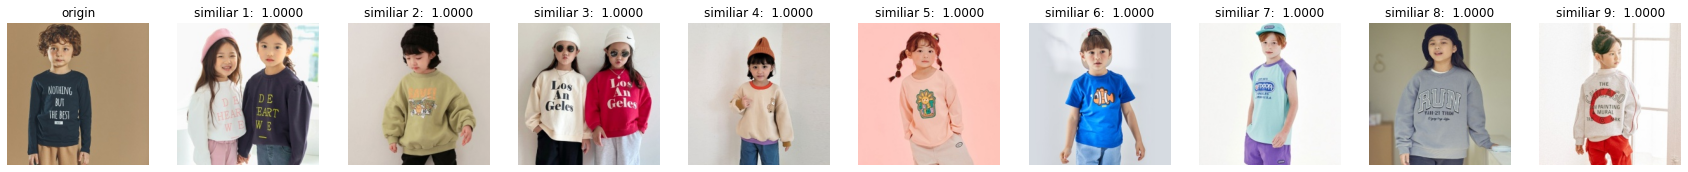

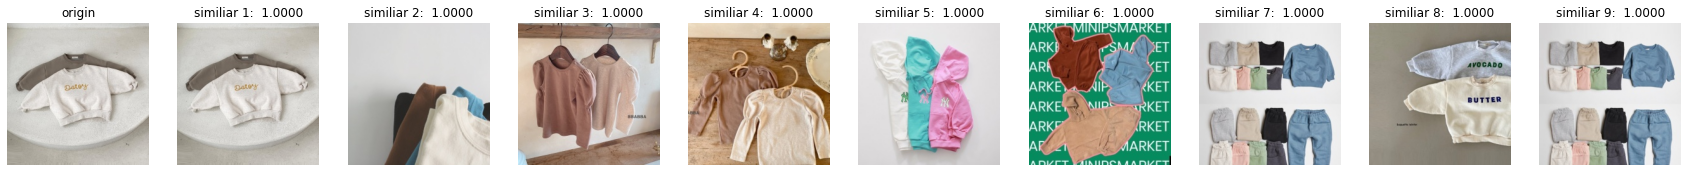

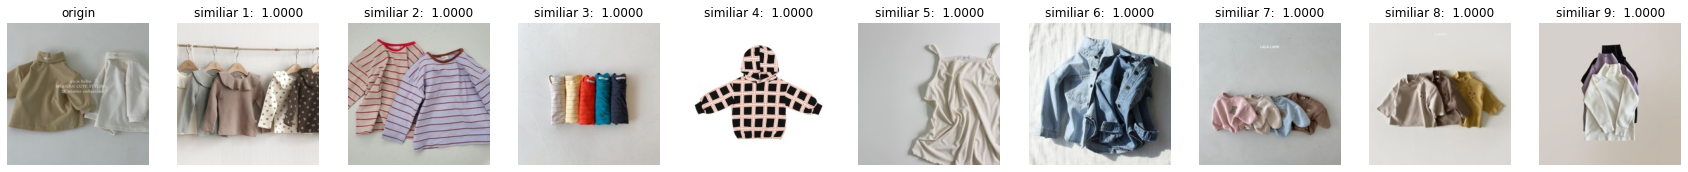

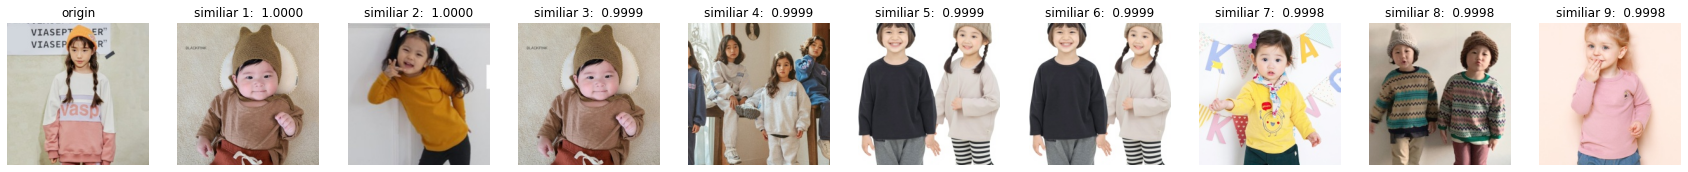

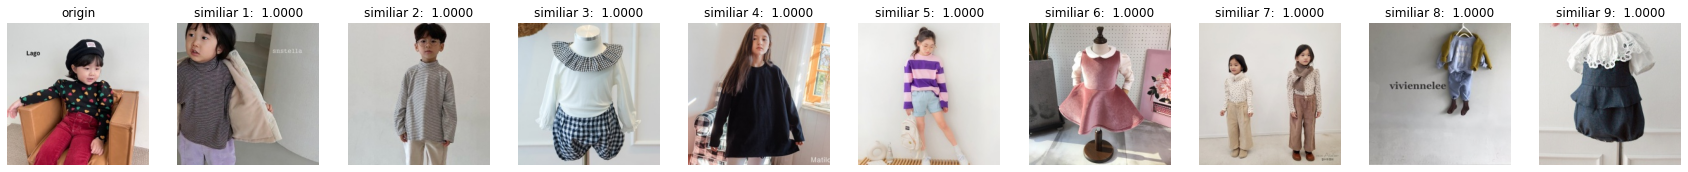

In [36]:
for filename in random_samples:
    show_sim_image(filename)
    print('\n')